<a href="https://colab.research.google.com/github/NilanjanChattopadhyay/miscellaneous-DL-experiments/blob/master/Notebooks/Object_Detection_FasterRCNN_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Objective -** Train a model that can localize and classify each instance of person and car in a given image

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
import os
os.chdir('/content/gdrive/My Drive/competitions/Eagle View')
# Downloading Data
# !wget https://evp-ml-data.s3.us-east-2.amazonaws.com/ml-interview/openimages-personcar/trainval.tar.gz
os.getcwd(), os.listdir()

('/content/gdrive/My Drive/competitions/Eagle View',
 ['trainval.tar.gz', 'Data'])

In [3]:
# !mkdir Data

In [4]:
# Extracting Files
# import tarfile
# my_tar = tarfile.open('trainval.tar.gz')
# my_tar.extractall('/content/gdrive/My Drive/competitions/Eagle View/Data')
# my_tar.close()

In [5]:
import json 
with open('/content/gdrive/My Drive/competitions/Eagle View/Data/trainval/annotations/bbox-annotations.json') as json_file:
  Annotations = json.load(json_file)

In [6]:
# Annotations are in COCO format
Annotations['annotations'][1]

{'area': 0.12261072794596355,
 'bbox': [848, 216, 175, 551],
 'category_id': 1,
 'id': 1,
 'image_id': 0,
 'iscrowd': 0,
 'license': 2,
 'segmentation': []}

In [7]:
# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import torch
import torch.utils.data
import torchvision
from PIL import Image
from pycocotools.coco import COCO
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [8]:
# Defining Dataset Class

class EVDataset(torch.utils.data.Dataset):

  def __init__(self,
               root='/content/gdrive/My Drive/competitions/Eagle View/Data/trainval/images',
               annotation='/content/gdrive/My Drive/competitions/Eagle View/Data/trainval/annotations/bbox-annotations.json',
               isValid=False,
               transforms=None):
    self.root = root
    self.transforms = transforms
    self.coco = COCO(annotation)
    # Holding out 400 images for Validation
    if isValid:
      self.ids = list(sorted(self.coco.imgs.keys()))[:400]
    else:
      self.ids = list(sorted(self.coco.imgs.keys()))[400:]
    
  def __getitem__(self, index):
    coco = self.coco
    img_id = self.ids[index]
    ann_ids = coco.getAnnIds(imgIds=img_id)
    coco_annotation = coco.loadAnns(ann_ids)
    path = coco.loadImgs(img_id)[0]["file_name"]
    img = Image.open(os.path.join(self.root, path))
    num_objs = len(coco_annotation)

    # Bounding boxes for objects
    # In coco format, bbox = [xmin, ymin, width, height]
    # In pytorch, the input should be [xmin, ymin, xmax, ymax]
    boxes = []
    labels = []
    areas = []
    iscrowd = []
    for i in range(num_objs):
      xmin = coco_annotation[i]["bbox"][0]
      ymin = coco_annotation[i]["bbox"][1]
      xmax = xmin + coco_annotation[i]["bbox"][2]
      ymax = ymin + coco_annotation[i]["bbox"][3]
      if xmin == xmax:
        continue
      if ymin == ymax:
        continue
      if coco_annotation[i]["area"] <= 0:
        continue
      boxes.append([xmin, ymin, xmax, ymax])
      labels.append(coco_annotation[i]["category_id"])
      areas.append(coco_annotation[i]["area"])
      iscrowd.append(coco_annotation[i]["iscrowd"])

    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    labels = torch.as_tensor(labels, dtype=torch.int64)
    img_id = torch.tensor([img_id])
    areas = torch.as_tensor(areas, dtype=torch.float32)
    iscrowd = torch.as_tensor(areas, dtype=torch.int64)

    # Annotation is in dictionary format
    my_annotation = {}
    my_annotation["boxes"] = boxes
    my_annotation["labels"] = labels
    my_annotation["image_id"] = img_id
    my_annotation["area"] = areas
    my_annotation["iscrowd"] = iscrowd
    
    if self.transforms is not None:
      img = self.transforms(img)
      
    return img, my_annotation

  def __len__(self):
    return len(self.ids)

In [9]:
def get_transform():
  custom_transforms = [torchvision.transforms.ToTensor()]
  return torchvision.transforms.Compose(custom_transforms)

In [10]:
def collate_fn(batch):
  return tuple(zip(*batch))

### Faster RCNN

Paper - https://arxiv.org/abs/1506.01497

In [11]:
num_classes = 3
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [12]:
TrainDataset = EVDataset(isValid=False, transforms=get_transform())
ValidDataset = EVDataset(isValid=True, transforms=get_transform())

TrainDataLoader = torch.utils.data.DataLoader(TrainDataset,
                                              batch_size=8,
                                              shuffle=True,
                                              num_workers=4,
                                              collate_fn=collate_fn)

ValidDataLoader = torch.utils.data.DataLoader(ValidDataset,
                                              batch_size=8,
                                              shuffle=False,
                                              num_workers=4,
                                              collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
loading annotations into memory...
Done (t=0.13s)
creating index...
index created!


In [13]:
num_epochs = 5
len_dataloader = len(TrainDataLoader)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001)
# lr_scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.005, step_size_up=(len_dataloader*num_epochs)//2, verbose=True)
lr_scheduler = None

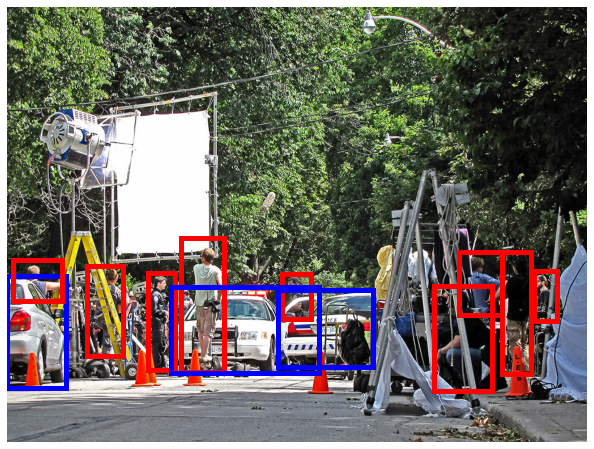

In [14]:
# Plotting True Labels
# Red Boxes for Humans
# Blue Boxes for Cars
images, targets = next(iter(TrainDataLoader))
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

sample = images[0].permute(1,2,0).cpu().numpy()
a_boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
i = 0
for box in a_boxes:
  if targets[0]['labels'][i] == 1:
    rect1 = patches.Rectangle((box[0], box[1]),box[2]-box[0],box[3]-box[1], linewidth=5, edgecolor='r', facecolor='none')
  else:
    rect1 = patches.Rectangle((box[0], box[1]),box[2]-box[0],box[3]-box[1], linewidth=5, edgecolor='b', facecolor='none')
  ax.add_patch(rect1)
  i+=1

ax.set_axis_off()
ax.imshow(sample)

In [15]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [16]:
loss_hist = Averager()

for epoch in range(num_epochs):
  loss_hist.reset()

  for imgs, targets in TrainDataLoader:

    model.train()
    torch.cuda.empty_cache()

    imgs = list(img.to(device) for img in imgs)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    loss_dict = model(imgs, targets)

    losses = sum(loss for loss in loss_dict.values())
    loss_value = losses.item()
    loss_hist.send(loss_value)

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()
    
    if lr_scheduler is not None:
      lr_scheduler.step()

  print(f"\nEpoch #{epoch}") 
  print(f"\tTrain Loss: {loss_hist.value}")
  loss_hist.reset()

  for imgs, targets in ValidDataLoader:
    with torch.no_grad():
      imgs = list(img.to(device) for img in imgs)
      targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
      loss_dict = model(imgs, targets)
      losses = sum(loss for loss in loss_dict.values())
      loss_value = losses.item()
      loss_hist.send(loss_value)
  print(f"\tValid Loss: {loss_hist.value}")

/usr/local/lib/python3.6/dist-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)



Epoch #0
	Train Loss: 1.0881626883278723
	Valid Loss: 0.9460734766721726

Epoch #1
	Train Loss: 0.832460174223651
	Valid Loss: 0.7765518623590469

Epoch #2
	Train Loss: 0.706863302251567
	Valid Loss: 0.699309886097908

Epoch #3
	Train Loss: 0.6593148896227712
	Valid Loss: 0.6765090960264206

Epoch #4
	Train Loss: 0.6377183767764465
	Valid Loss: 0.6613818079233169


In [17]:
torch.cuda.empty_cache()

images, targets = next(iter(ValidDataLoader))
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
model.eval()
cpu_device = torch.device("cpu")
with torch.no_grad():
  outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

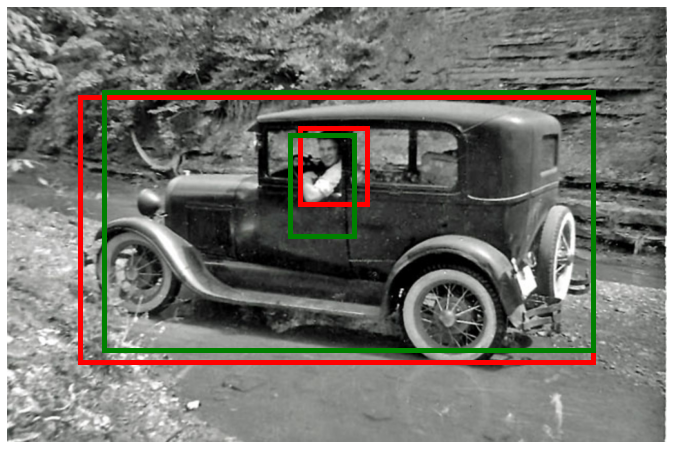

In [18]:
# Plotting True Labels vs Predicted Labels
# Red Boxes for True Labels
# Green Boxes for Predictions

i = 3
sample = images[i].permute(1,2,0).cpu().numpy()

a_boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)

p_boxes = outputs[i]['boxes'].data.cpu().numpy()
scores = outputs[i]['scores'].data.cpu().numpy()
p_boxes = p_boxes[scores >= 0.5].astype(np.int32)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in a_boxes:
  rect1 = patches.Rectangle((box[0], box[1]),box[2]-box[0],box[3]-box[1], linewidth=5, edgecolor='r', facecolor='none')
  ax.add_patch(rect1)

for box in p_boxes:
  rect2 = patches.Rectangle((box[0], box[1]),box[2]-box[0],box[3]-box[1], linewidth=5, edgecolor='g', facecolor='none')
  ax.add_patch(rect2)
    
ax.set_axis_off()
ax.imshow(sample)